In [4]:
import sys
!{sys.executable} -m pip install -U imbalanced-learn

In [11]:
import os
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
# Statistics, EDA, metrics libraries
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer

# Modeling libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict,KFold, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.metrics import SCORERS
from numpy import argmax
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score


import json

In [6]:
%cd /mnt/home/d.alvarez/Documents/Internship/

print("File location using os.getcwd():", os.getcwd())

/mnt/home/d.alvarez/Documents/Internship
File location using os.getcwd(): /mnt/home/d.alvarez/Documents/Internship


In [12]:
data = pd.read_csv("data/training_data/final_training_set.csv")

#data = data[data.conformation_type.isin(classes)]

data.reset_index(drop=True, inplace=True)

residue_info = data[['pdb_id','asymID','compID', 'insCode', 'seqNum', 'seqID_besttls']]
conformation_type = data['conformation_type']
#df = data.drop(["conformation_type",'asymID','compID', 'insCode', 'seqNum', 'seqID_besttls','index'], axis=1)
df = data.loc[:, 'cn_m1':'dssp_p2T']
#df = df.iloc[:, 0:80]

conformation_type

/tmp/ipykernel_54482/2747474432.py:1: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/training_data/final_training_set.csv")


0           random
1           random
2         pep_flip
3           random
4           random
            ...   
249204      random
249205      random
249206      random
249207      random
249208      random
Name: conformation_type, Length: 249209, dtype: object

In [13]:
labelencoder = LabelEncoder()

conformation_type_encoded = pd.Series(labelencoder.fit_transform(conformation_type), name = "encoded_label")

label_conformation = pd.concat([conformation_type, conformation_type_encoded], axis=1)

label = pd.concat([label_conformation,residue_info], axis=1)

unique_label = label_conformation.drop_duplicates(ignore_index=True)

RANDOM_STATE = 42

unique_label



,conformation_type,encoded_label
0,random,3
1,pep_flip,2
2,o_flip,1
3,n_flip,0


In [14]:
X = df
X_train, X_test, y_train_info, y_test_info = train_test_split(X, label, test_size=0.25, random_state = RANDOM_STATE, stratify=label["encoded_label"])


y_train_info['encoded_label_binary'] = y_train_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)
y_test_info['encoded_label_binary'] = y_test_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)

y_train = y_train_info["encoded_label"].array
y_test = y_test_info["encoded_label"].array


In [15]:
RANDOM_STATE = 42
X = df
X_train, X_test, y_train_info, y_test_info = train_test_split(X, label, test_size=0.25, random_state = 42, stratify=label["encoded_label"])


y_train = y_train_info["encoded_label"].array
y_test = y_test_info["encoded_label"].array

y_train_info

clf = pickle.load(open('provisional_multiclass.pkl', 'rb'))


y_pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)
roc_auc_score(y_test, pred_prob, multi_class='ovr',average="macro")

0.9262149480731379

In [53]:

balanced_accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred,average= "macro")
precision_score(y_test, y_pred,average= "macro")
#roc_auc_score(y_test, y_pred,average= "macro", multi_class="ovr")
f1_score(y_test, y_pred ,average= "macro")

balanced_accuracy_all = [balanced_accuracy_score(y_test, y_pred)]
recall_all = [recall_score(y_test, y_pred,average= "macro")]
precision_all = [precision_score(y_test, y_pred,average= "macro")]
f1_score_all = [f1_score(y_test, y_pred,average= "macro")]
roc_auc_all = [roc_auc_score(y_test, pred_prob, multi_class='ovr',average="macro")]

scores_df = pd.DataFrame(list(zip(balanced_accuracy_all, recall_all,precision_all,f1_score_all,roc_auc_all)),
               columns =['balanced_accuracy', 'recall', 'precision' ,'f1_score','roc_auc'])
scores_df 

,balanced_accuracy,recall,precision,f1_score,roc_auc
0,0.681919,0.681919,0.503326,0.536654,0.926215


In [16]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [17]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (1, 1))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    ax.plot(fpr, tpr)
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")

In [19]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [20]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)



labelling complete
labelling complete
labelling complete


TypeError: 'Axes' object is not subscriptable

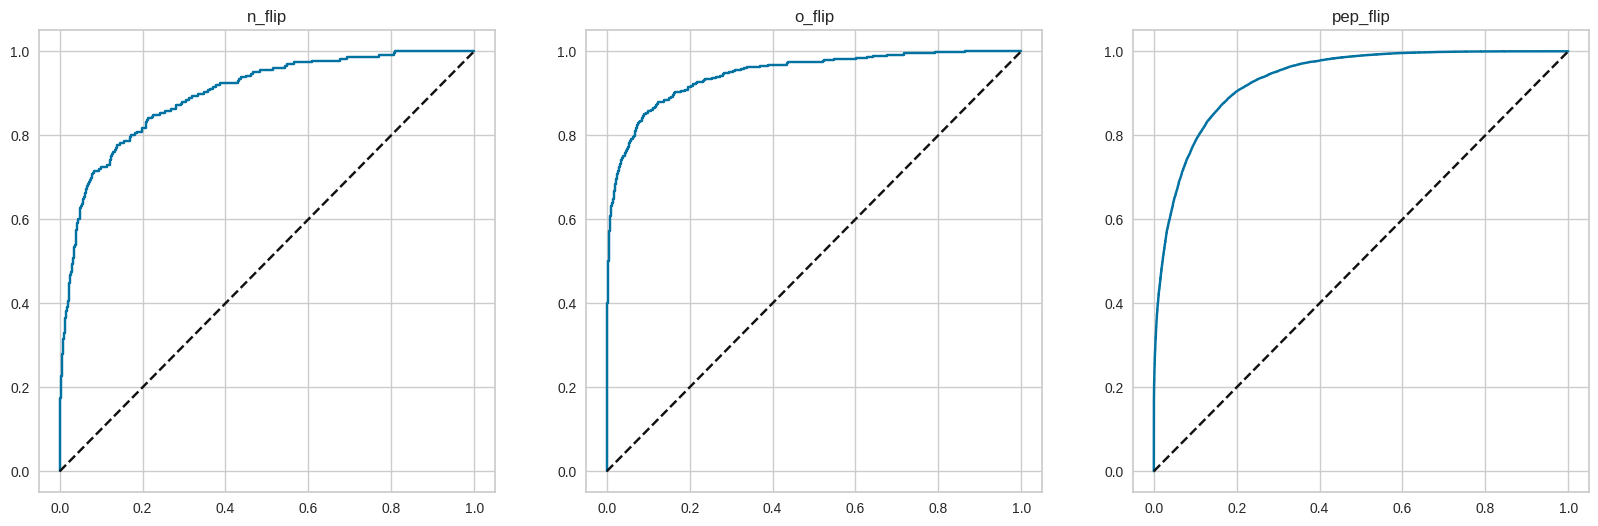

In [21]:
from matplotlib import pyplot
# Plots the Probability Distributions and the ROC Curves One vs Rest

label_binarizer = LabelBinarizer().fit(y_train)

y_onehot_test = label_binarizer.transform(y_test)

classes = unique_label.sort_values(by=['encoded_label'])['conformation_type'].tolist()

roc_auc_ovr = {}
y_proba = clf.predict_proba(X_test)

fpr_all = []
tpr_all = []
thresholds_all = []

fig = plt.figure(figsize = (20, 6))

for i in range(len(classes)-1):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [row[i]for row in y_onehot_test]
    #df_aux['class'] = [1 if y == i else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    #print(df_aux["class"].unique())
    #print(len(df_aux))
    
    print("labelling complete")
    
    #Plots the probability distribution for the class and the rest
    
    ax = plt.subplot(1, 3, i+1)
   
    fpr, tpr, thresholds = roc_curve(df_aux['class'], df_aux['prob'])
    
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    thresholds_all.append(thresholds)
     
    
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax)
    #ax.set_title("ROC Curve OvR")
    x = np.linspace(0, 1, 1000)
    ax.plot(x, x,'--k',label='Random Chance');
    ax.set_title(c)
    
    
    # Calculates the ROC AUC OvR
    #roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
handles, labels = ax[0].get_legend_handles_labels()  
fig.legend(handles, labels, loc='lower right')
fig.suptitle(f'ROC Curve Line')
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.tight_layout()

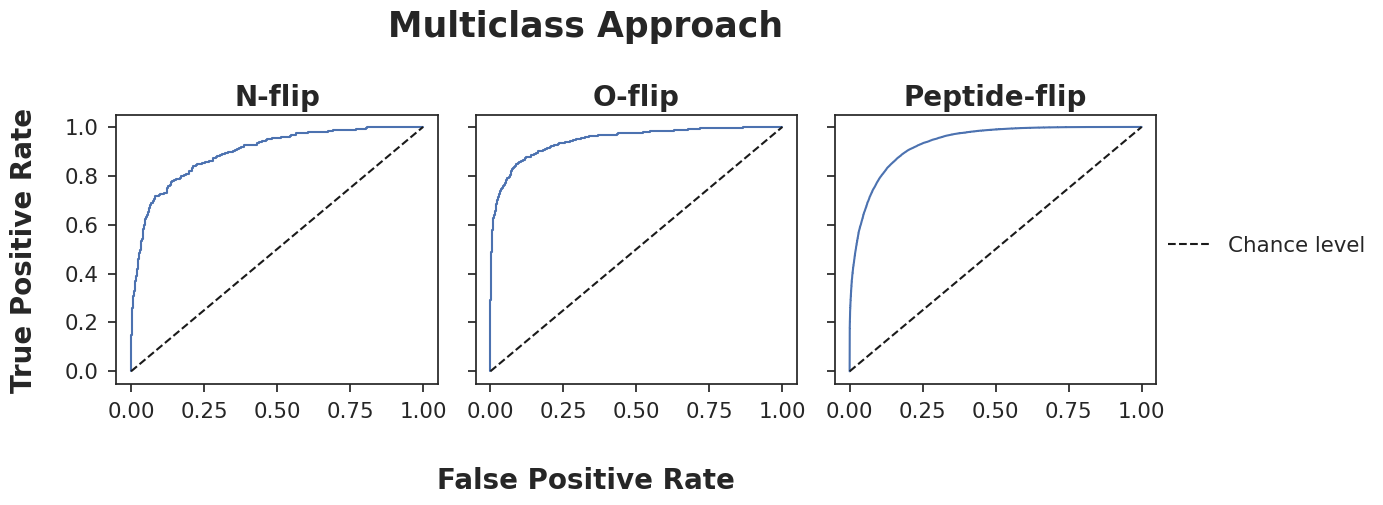

In [34]:
sns.set_theme(style="whitegrid",font_scale = 1.4)
sns.set_style("white")
sns.set_style("ticks")
fig, ax= plt.subplots(1, 3, sharex=True, sharey=True,figsize=(12, 5))
x = np.linspace(0, 1, 1000)

ax[0].plot(fpr_all[0], tpr_all[0])
ax[0].plot(x, x,'--k');
ax[0].set_title('N-flip',fontdict=dict(weight='bold'),fontsize = 20)

ax[1].plot(fpr_all[1], tpr_all[1])
ax[1].plot(x, x,'--k');
ax[1].set_title('O-flip',fontdict=dict(weight='bold'),fontsize = 20)

ax[2].plot(fpr_all[2], tpr_all[2])
ax[2].plot(x, x,'--k',label='Chance level');
ax[2].set_title('Peptide-flip',fontdict=dict(weight='bold'),fontsize = 20)

"""ax[3].plot(fpr_all[3], tpr_all[3])
ax[3].plot(x, x,'--k',label='Random Chance');
ax[3].set_title('No-correction')"""

handles, labels = ax[2].get_legend_handles_labels()
fig.legend(bbox_to_anchor=(1.165, 0.45), loc='lower right')
fig.suptitle(f'Multiclass Approach',fontweight='bold',fontsize = 25)
fig.supxlabel('False Positive Rate',fontsize = 20,fontweight='bold')
fig.supylabel('True Positive Rate',fontsize = 20,fontweight='bold')

plt.tight_layout()

plt.show()

In [17]:
classes = unique_label.sort_values(by=['encoded_label'])['conformation_type'].tolist()

classes

['n_flip', 'o_flip', 'pep_flip', 'random']

In [16]:
unique_label

,conformation_type,encoded_label
0,random,3
1,pep_flip,2
2,o_flip,1
3,n_flip,0


In [1]:
fs = clf.best_estimator_.named_steps['kbest']

features = np.array(X_train.columns)
selected_features = features[fs.get_support()]

print("Features selected: ", selected_features)
print("\n The best parameters across ALL searched params:\n", clf.best_params_)

scores = fs.scores_


features = list(map(str, features))

feature_importance = pd.DataFrame(list(zip(features, scores)), columns =['features', 'scores']).sort_values('scores', ascending=False).head(10) 

#feature_importance = feature_importance[feature_importance['scores'] > 250]

fig = plt.figure(figsize= (20,20))
ax = sns.barplot(data=feature_importance, x="scores", y="features")
plt.show()



NameError: name 'clf' is not defined

In [10]:
feature_importance.head(10)

,features,scores
96,donor_1,667.244413
97,acceptor_1,547.915583
93,bo_r0,537.785471
89,bc_r0,457.056326
82,bn_p1,425.184516
81,bn_r0,385.521699
50,ncacb_p1,376.973011
85,bca_r0,375.819377
104,dphi,366.933886
100,zram_p1,330.133018


In [58]:
print(classification_report(y_test, y_pred))

models_list = ["n-flip","o-flip","pep-flip"]
balanced_accuracy_score(y_test, y_pred)
recall_score(y_test, y_pred,average= "macro")
precision_score(y_test, y_pred,average= "macro")
#roc_auc_score(y_test, y_pred,average= "macro", multi_class="ovr")
f1_score(y_test, y_pred ,average= "macro")

balanced_accuracy_all = balanced_accuracy_score(y_test, y_pred)
recall_all = recall_score(y_test, y_pred,average= "macro")
precision_all = precision_score(y_test, y_pred,average= "macro")
f1_score_all = f1_score(y_test, y_pred,average= "macro")
roc_auc_all = roc_auc_score(y_test, y_pred, multi_class= "ovr")

scores_df = pd.DataFrame(list(zip(models_list,balanced_accuracy_all, recall_all,precision_all,f1_score_all,roc_auc_all)),
               columns =['models', 'balanced_accuracy', 'recall', 'precision' ,'f1_score','roc_auc' ])


              precision    recall  f1-score   support

           0       0.07      0.40      0.12       225
           1       0.22      0.66      0.33       380
           2       0.85      0.85      0.85     30557
           3       0.87      0.82      0.84     31141

    accuracy                           0.83     62303
   macro avg       0.50      0.68      0.54     62303
weighted avg       0.85      0.83      0.84     62303



AxisError: axis 1 is out of bounds for array of dimension 1

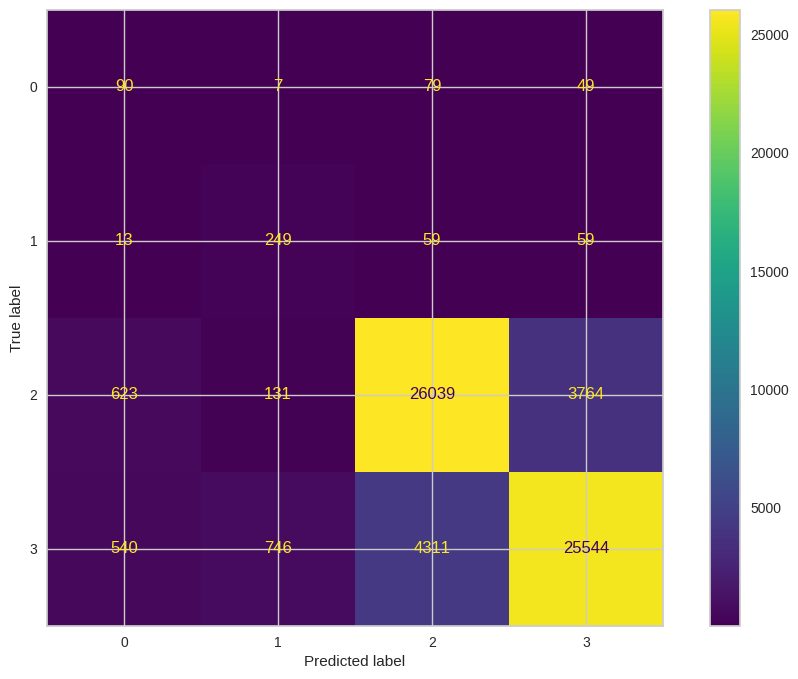

In [12]:


# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
cmp.plot(ax=ax)

plt.show();

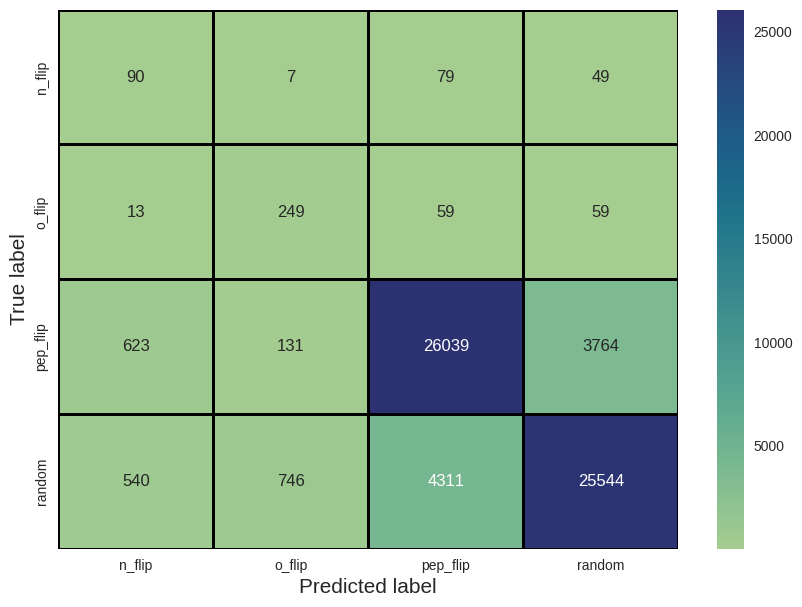

In [11]:

classes = unique_label.sort_values(by=['encoded_label'])['conformation_type']


df_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns= classes, index=classes)

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black')
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15

plt.show()

In [34]:
unique_label

,conformation_type,encoded_label
0,random,3
1,pep_flip,2
2,o_flip,1
3,n_flip,0


In [46]:
y_test_info['y_pred'] = y_pred

validate_df = y_test_info

validate_df

,conformation_type,encoded_label,pdb_id,asymID,compID,insCode,seqNum,seqID_besttls,y_pred
104449,random,1,6md6,A,PRO,NaN,89,93,1
20987,random,1,3mtr,A,PHE,NaN,474,74,1
87775,random,1,5s78,B,GLY,NaN,289,91,1
114428,random,1,7a8y,B,GLY,NaN,52,28,1
13236,random,1,3e01,A,PRO,NaN,433,433,1
...,...,...,...,...,...,...,...,...,...
8071,random,1,2y73,A,GLY,NaN,309,309,0
51374,random,1,2dps,B,ASN,NaN,92,92,1
121658,random,1,7p5f,A,ALA,NaN,548,245,1
24918,random,1,3qva,A,PRO,NaN,16,22,1


In [48]:
false_negatives = validate_df[(validate_df['encoded_label'] == 0) & (validate_df['y_pred'] == 1)]
false_negatives

,conformation_type,encoded_label,pdb_id,asymID,compID,insCode,seqNum,seqID_besttls,y_pred
103376,o_flip,0,6kvo,A,SER,NaN,245,141,1
67616,o_flip,0,4u1w,A,LEU,NaN,639,632,1
12360,o_flip,0,3d0i,C,THR,NaN,402,79,1
67617,o_flip,0,4u1w,C,LYS,NaN,434,427,1
33510,o_flip,0,4biw,A,ALA,NaN,220,10,1
...,...,...,...,...,...,...,...,...,...
80838,o_flip,0,5jsz,D,ARG,NaN,63,58,1
106061,o_flip,0,6oht,A,GLY,NaN,81,68,1
75113,o_flip,0,5d4c,K,GLY,NaN,931,931,1
60396,o_flip,0,4lfb,E,ASN,NaN,127,127,1


Text(95.72222222222221, 0.5, 'True label')

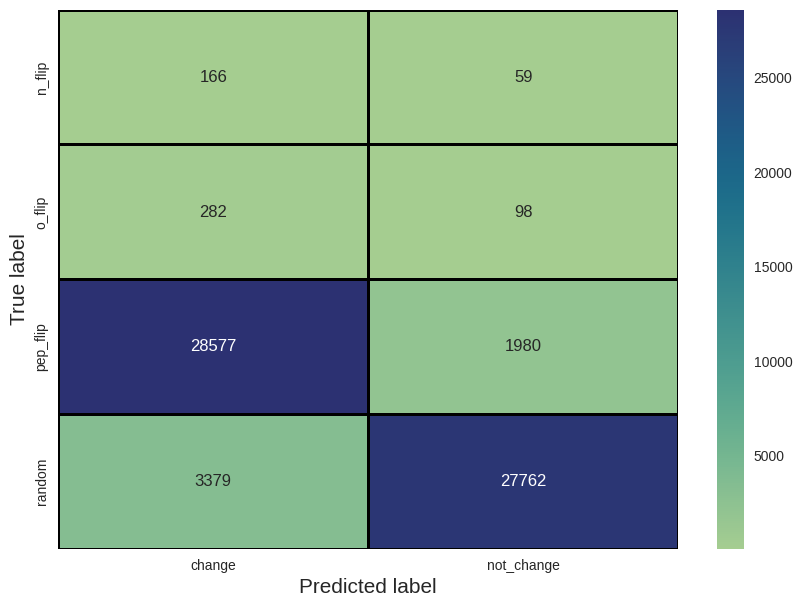

In [23]:

#binary classifier

y_test_info['y_pred'] = y_pred

action = ['change', 'not_change']

classes = unique_label.sort_values(by=['encoded_label'])['conformation_type']

confusion_matrix = y_test_info.groupby(["conformation_type", "y_pred"]).size().unstack().to_numpy()



df_matrix = pd.DataFrame(confusion_matrix, columns= action, index=classes)



plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black')
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15

,cn_m1,cn_r0,cn_p1,cn_p2,nca_m1,nca_r0,nca_p1,nca_p2,cac_m1,cac_r0,...,dssp_r0loop,dssp_r0T,dssp_p1E,dssp_p1H,dssp_p1loop,dssp_p1T,dssp_p2E,dssp_p2H,dssp_p2loop,dssp_p2T
0,1.333522,1.341286,1.340351,1.335669,1.459877,1.482715,1.472931,1.460420,1.517286,1.535690,...,0,1,0,0,0,1,0,0,0,1
1,1.336176,1.331936,1.336577,1.336073,1.468841,1.449212,1.458819,1.466655,1.539117,1.544378,...,0,0,0,1,0,0,0,1,0,0
2,1.333920,1.333011,1.339610,1.330200,1.468895,1.469672,1.465948,1.482521,1.526620,1.539556,...,0,0,0,0,0,1,0,0,1,0
3,1.335695,1.332759,1.325632,1.331060,1.462837,1.464949,1.463162,1.463961,1.537382,1.541931,...,0,1,0,0,1,0,0,0,0,1
4,1.325933,1.329123,1.330407,1.336208,1.460959,1.456025,1.456004,1.465040,1.521179,1.530412,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249204,1.328074,1.324373,1.327440,1.342506,1.482662,1.484368,1.480139,1.488597,1.529884,1.538976,...,0,0,0,1,0,0,0,1,0,0
249205,1.327594,1.340456,1.324731,1.354865,1.475671,1.509820,1.483358,1.483427,1.525283,1.535602,...,0,1,0,0,0,1,0,0,1,0
249206,1.323905,1.333174,1.322841,1.329882,1.480838,1.449522,1.472995,1.456382,1.529218,1.507526,...,0,1,0,0,1,0,0,0,1,0
249207,1.326609,1.318511,1.322698,1.333322,1.482826,1.470583,1.467768,1.479899,1.528621,1.526754,...,0,0,0,1,0,0,0,0,0,1


In [1]:
def print_scores(scores):
   
    models = ["KNN", "RFC", "SVM", "XGB"]

    for score, model in zip(scores, models):
        
        print()
        print(f'{model} classifier model scores:')

        print(f"CV all accuracy scores: {score[0]}")
        print(f"CV all AUC scores: {score[1]}")
        print(f"CV all F1 scores: {score[2]}")

In [31]:
scores_1 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_2 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_3 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_4 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
models = ["KNN", "RFC", "SVM", "XGB"]
scores = [scores_1,scores_2,scores_3,scores_4]
model_dict={}
for score, model in zip(scores, models):
    if not model in model_dict:
        model_dict[model] = {"mean":{},"std":{}}
    model_dict[model]["mean"] = {k:np.mean(v) for k, v in score.items()}
    model_dict[model]["std"] = {k:np.std(v) for k, v in score.items()}
    model_dict[model]["scores"] = {k:list(v)for k, v in score.items()}
    
model_dict





{'KNN': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'std': {'acc': 1.4142135623730951,
   'AUC': 1.4142135623730951,
   'F1': 1.4142135623730951,
   'recall': 1.4142135623730951,
   'balanced_accuracy': 1.4142135623730951},
  'scores': {'acc': [1, 2, 3, 4, 5],
   'AUC': [1, 2, 3, 4, 5],
   'F1': [1, 2, 3, 4, 5],
   'recall': [1, 2, 3, 4, 5],
   'balanced_accuracy': [1, 2, 3, 4, 5]}},
 'RFC': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'std': {'acc': 1.4142135623730951,
   'AUC': 1.4142135623730951,
   'F1': 1.4142135623730951,
   'recall': 1.4142135623730951,
   'balanced_accuracy': 1.4142135623730951},
  'scores': {'acc': [1, 2, 3, 4, 5],
   'AUC': [1, 2, 3, 4, 5],
   'F1': [1, 2, 3, 4, 5],
   'recall': [1, 2, 3, 4, 5],
   'balanced_accuracy': [1, 2, 3, 4, 5]}},
 'SVM': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'st

In [55]:


mean = {k:np.mean(v) for k, v in scores.items()}
std = {k:np.std(v) for k, v in scores.items()}

std

with open('readme.txt', 'w') as f:

    models = ["KNN", "RFC", "SVM", "XGB"]
    metrics = ["acc","AUC","F1","recall","balanced_accuracy"]

    for score, model in zip(scores, models):


        
        
        f.write(f'{model} classifier model scores:\n')
        f.write(f"CV all accuracy scores: {score[0]}\n")
        f.write(f"CV all AUC scores: {score[1]}\n")
        f.write(f"CV all F1 scores: {score[2]}\n")
        f.write('\n')
    

{'acc': 1.4142135623730951,
 'AUC': 1.4142135623730951,
 'F1': 1.4142135623730951,
 'recall': 1.4142135623730951,
 'balanced_accuracy': 1.4142135623730951}